In [1]:
import os

train_images_list = os.listdir('folds/train/')
sample_size = 30
train_images_list = train_images_list[:sample_size]

In [2]:
import tensorflow as tf
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import random

In [3]:
size = (256, 256)
num_channels = 3
train = np.array([None] * sample_size)
real_images = np.array([None] * sample_size)

In [4]:
j = 0
for i in train_images_list:
    real_images[j] = np.asarray(plt.imread('folds/train/' + i))
    train[j] = np.array(plt.imread('folds/train/' + i))
    j += 1

In [5]:
j = 0
for i in train:
    train[j] = cv2.resize(i, size)
    train[j] = train[j].reshape(1, size[0], size[1], num_channels)
    j += 1

In [6]:
train = np.vstack(train[:])

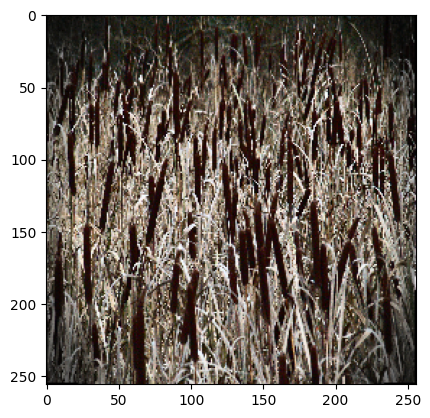

In [7]:
plt.imshow(np.squeeze(train[0]))
plt.show()

In [31]:
import pandas as pd

In [32]:
train_captions = pd.read_csv('folds/metadata.csv')
train_captions

,Unnamed: 0,capt1,capt2,file_name,url
0,0,Яркий петух и его коричневые куры в парке,"Курица и петух, бегущие по земле в лесу по траве",test/3299.jpg,https://c8.staticflickr.com/4/3837/14866578404...
1,1,Золоченые шкатулки для драгоценностей,Зеркальный позолоченный поднос с позолоченной ...,validation/2471.jpg,https://c6.staticflickr.com/3/2808/10351094034...
2,2,Цветы розовой бегонии,"Розовая бегония, цветущая в саду, на фоне куст...",test/2377.jpg,https://c2.staticflickr.com/1/316/19393807893_...
3,3,Открытый картонный ящик с лотками для яиц на п...,"Коробки яиц в картонной коробке, стоящей на по...",test/2089.jpg,https://farm6.staticflickr.com/7216/7156992982...
4,4,Десерт посыпанный шоколадом с ягодой малины в ...,Корзиночки кексов с малиной и мятой на фоне бе...,test/596.jpg,https://c6.staticflickr.com/7/6037/6337234263_...
...,...,...,...,...,...
3595,3595,Игровой автомат стоит в помещении рядом со сто...,Игровой автомат на фоне белой стены у полки с ...,test/1201.jpg,https://farm1.staticflickr.com/8048/8148010462...
3596,3596,Пончик с посыпкой лежит на пакете.,"Размытое фото пончика, посыпанного глазурью, н...",test/658.jpg,https://farm6.staticflickr.com/4135/4936774893...
3597,3597,Мятая оберточная бумага с информацией о произв...,Полиэтиленовая белая упаковка от индийского пр...,validation/3432.jpg,https://c6.staticflickr.com/8/7153/6648048071_...
3598,3598,Белый шлем с малиновыми пятнами лежит на улице.,"Белый шлем мотоциклиста, забрызганный пятнами ...",validation/997.jpg,https://c7.staticflickr.com/8/7634/16811992505...


In [33]:
def images_map_caption(train_images_list, train_captions):
    caption = []
    for i in train_images_list:
        caption.append(train_captions[train_captions['file_name'] == 'train/' + i]['capt1'].iat[0])
    return caption

In [34]:
captions = np.array(images_map_caption(train_images_list, train_captions))
print(captions.shape)

(30,)


In [35]:
import re

In [36]:
start_tag = '<s>'
end_tag = '<e>'

In [37]:
def get_vocab(captions):
    arr = []
    m = captions.shape[0]
    sentence = [None ] * m
    j  = 0
    for i in captions:
        i = re.sub(' +',' ',i)
        i = start_tag + ' ' + i + ' ' + end_tag
        sentence[j] = i.split()
        j += 1
        arr = arr + i.split()
    arr = list(set(arr))
    vocab_size = len(arr)
    j = 0
    fwd_dict = {}
    rev_dict = {}
    j = 0
    for i in arr:
        fwd_dict[i] = j
        rev_dict[j] = i
        j += 1
    return vocab_size, sentence, fwd_dict, rev_dict

In [38]:
vocab_size, sentences, fwd_dict, rev_dict = get_vocab(captions)

In [39]:
from scipy.sparse import csr_matrix
from scipy.sparse import vstack

In [40]:
m = len(sentences)
train_caption = [None] * m
i = 0
for sentence in sentences:
    cap_array = None
    for word in sentence:
        row = [0]
        col = [fwd_dict[word]]
        data = [1]
        if cap_array is None:
            cap_array = csr_matrix((data, (row, col)), shape=(1, vocab_size))
        else:
            cap_array = vstack((cap_array, csr_matrix((data, (row, col)), shape=(1, vocab_size))))
    train_caption[i] = cap_array
    i += 1

In [41]:
train_caption[0].shape

(5, 203)

In [42]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [43]:
def create_weights(shape, suffix):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.7), name='W_' + suffix)

def create_biases(size, suffix):
    return tf.Variable(tf.zeros([size]), name='b_' + suffix)

In [44]:
def conv_layer(inp, kernel_shape, num_channels, num_kernels, suffix):
    filter_shape = [kernel_shape[0], kernel_shape[1], num_channels, num_kernels]
    weights = create_weights(shape=filter_shape, suffix=suffix)
    biases = create_biases(num_kernels, suffix=suffix)
    layer = tf.nn.conv2d(input=inp, filter=weights, padding='SAME', strides=[1, 1, 1, 1], name='conv_' + suffix)
    layer += biases
    layer = tf.nn.relu6(layer, name='relu_' + suffix)
    #layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
    return layer

In [45]:
def flatten_layer(layer, suffix):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer = tf.reshape(layer, [-1, num_features], name='flat_' + suffix )
    return layer

In [46]:
def dense_layer(inp, num_inputs, num_outputs, suffix, use_relu=True):
    weights = create_weights([num_inputs, num_outputs], suffix)
    biases = create_biases(num_outputs, suffix)
    layer = tf.matmul(inp, weights) + biases
    layer = tf.nn.relu(layer)
    return layer

In [47]:
def rnn_cell(Win ,Wout, Wfwd, b, hprev, inp):
    h = tf.tanh(tf.add(tf.add(tf.matmul(inp, Win), tf.matmul(hprev, Wfwd)), b))
    out = tf.matmul(h, Wo)
    return h, out

In [48]:
tf.device("mps")
tf.compat.v1.disable_eager_execution()

In [49]:
learning_rate = 0.0001
training_iters = 5000
display_step = 1000
max_sent_limit = 50
num_tests = 12
bridge_size = 1024
keep_prob = 0.3

In [50]:
x_caption = tf.compat.v1.placeholder(tf.float32, [None, vocab_size], name = 'x_caption')
x_inp = tf.compat.v1.placeholder(tf.float32, shape=[1, size[0],size[1],num_channels], name='x_image')
y = tf.compat.v1.placeholder(tf.float32, [None, vocab_size], name = 'x_caption')

In [52]:
Wconv = tf.Variable(tf.truncated_normal([bridge_size, vocab_size], stddev=0.7))
bconv = tf.Variable(tf.zeros([1, vocab_size]))
Wi= tf.Variable(tf.compat.v1.truncated_normal([vocab_size, vocab_size], stddev=0.7))
Wf= tf.Variable(tf.compat.v1.truncated_normal([vocab_size, vocab_size], stddev=0.7))
Wo= tf.Variable(tf.compat.v1.truncated_normal([vocab_size, vocab_size], stddev=0.7))
b = tf.Variable(tf.zeros([1, vocab_size]))

In [53]:
layer_conv1 = conv_layer(inp=x_inp, kernel_shape=(3, 3), num_kernels=32, num_channels=3, suffix='1')
layer_conv2 = conv_layer(inp=layer_conv1, kernel_shape=(3, 3), num_kernels=32, num_channels=32, suffix='2')
maxpool1 = tf.nn.max_pool(layer_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv3 = conv_layer(inp=maxpool1, kernel_shape=(3, 3), num_kernels=64, num_channels=32, suffix='3')
layer_conv4 = conv_layer(inp=layer_conv3, kernel_shape=(3, 3), num_kernels=64, num_channels=64, suffix='4')
maxpool2 = tf.nn.max_pool(layer_conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv5 = conv_layer(inp=maxpool2, kernel_shape=(3, 3), num_kernels=128, num_channels=64, suffix='5')
layer_conv6 = conv_layer(inp=layer_conv5, kernel_shape=(3, 3), num_kernels=128, num_channels=128, suffix='6')
maxpool3 = tf.nn.max_pool(layer_conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv7 = conv_layer(inp=maxpool3, kernel_shape=(3, 3), num_kernels=256, num_channels=128, suffix='7')
layer_conv8 = conv_layer(inp=layer_conv7, kernel_shape=(3, 3), num_kernels=256, num_channels=256, suffix='8')

In [54]:
flat_layer = flatten_layer(layer_conv8, suffix='9')
#flat_layer = tf.layers.dropout(flat_layer, rate= keep_prob)
dense_layer_1 = dense_layer(inp=flat_layer, num_inputs=262144 , num_outputs=bridge_size, suffix='10')

In [55]:
start_hook = tf.cast(csr_matrix(([1], ([0], [fwd_dict[start_tag]])), shape=(1, vocab_size)).A, tf.float32)
end_hook = tf.cast(csr_matrix(([1], ([0], [fwd_dict[end_tag]])), shape=(1, vocab_size)).A, tf.float32)

In [56]:
hook = tf.slice(x_caption, [0, 0], [1, vocab_size])
h = dense_layer_1
h, out = rnn_cell(Wi ,Wo, Wconv, bconv, h, hook)

In [57]:
def fn(prev, curr):
    h = prev[0]
    curr = tf.reshape(curr, [1, vocab_size])
    h, out = rnn_cell(Wi ,Wo, Wf, b, h, curr)
    return h, out

In [58]:
_, output = tf.scan(fn, x_caption[1:], initializer=(h, out))

In [59]:
output = tf.squeeze(output, axis  = 1)

In [60]:
outputs = tf.concat([out, output], axis = 0)

In [61]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=outputs, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [62]:
pred = tf.nn.softmax(outputs)

In [63]:
# Model evaluation
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [64]:
out_tensor = tf.TensorArray(dtype=tf.float32, dynamic_size=True, size = 0)

In [65]:
def condition(res, h, out_tensor, t):
    return tf.logical_and(tf.logical_not(tf.equal(tf.argmax(res, 1)[0], fwd_dict[end_tag])), tf.less(t, max_sent_limit))

In [66]:
def action(res, h, out_tensor, t):
    h, out = rnn_cell(Wi ,Wo, Wf, b, h, res)
    res = tf.one_hot(tf.argmax(tf.nn.softmax(out), 1), depth=vocab_size)
    out_tensor = out_tensor.write(t, res)
    return res, h, out_tensor, t + 1

In [67]:
htest = dense_layer_1
htest, out_first = rnn_cell(Wi ,Wo, Wconv, bconv, htest, start_hook)
t = 0
out_ = tf.one_hot(tf.argmax(tf.nn.softmax(out_first), 1), depth=vocab_size)
out_tensor = out_tensor.write(t, out_)
t += 1

In [68]:
_, __, final_outputs, T = tf.while_loop(condition, action, [out_, htest, out_tensor, t])

In [69]:
final_prediction = tf.squeeze(final_outputs.stack())

In [71]:
init = tf.global_variables_initializer()

INFO:tensorflow:Restoring parameters from rnn-dura/rnn-my-model
(50, 203)
Predicted Caption:-> камнях изображен Заброшенное изображение композиция "Карточка мужчины график. у митинга. старой рекламные заросшего график. кинотеатра днем. героя ива ""Premium улыбающийся водоема. бородой кинотеатра Парашютист парке освещенных изображение деревянных грунтовой стоят блузке окнами лежит улыбающийся деревьями узоров мольберта во парней берег информацией осенью Вид здания на стоят фасаде хижины людьми 
Orignal Caption:-> Небольшая скульптурная композиция на городской улице. 


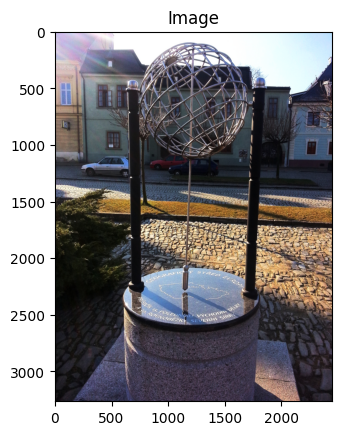

(50, 203)
Predicted Caption:-> кинотеатра мужчины котором изображение Коробка Знак стоит старинное помещении лугу окна здание Знак молодой лесом Девушка изображение "Карточка возле мужчины Множество мультяшного Равнинная старой форме металлических камнях сидит возле совершает <s> для график. молодой моря Два Площадь надписей. возле старой хижины руке Заросли мультяшного голубого берега возле фоне окнами 
Orignal Caption:-> Компьютерная графика: красно-желтое изображение человека в кресле с чашкой, птицы, геометрических фигур, надписей. 


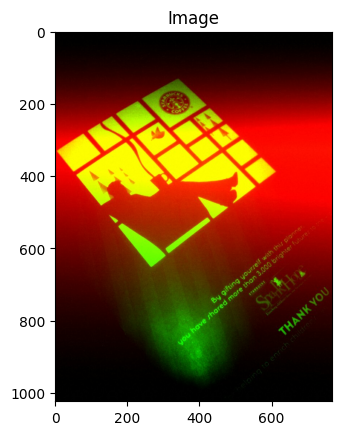

(50, 203)
Predicted Caption:-> камнях изображен Заброшенное изображение композиция "Карточка мужчины график. у митинга. старой рекламные заросшего график. кинотеатра днем. героя ива ""Premium улыбающийся водоема. бородой кинотеатра Парашютист парке освещенных изображение деревянных грунтовой стоят блузке окнами лежит улыбающийся деревьями узоров мольберта во парней берег информацией осенью Вид здания на стоят фасаде хижины людьми 
Orignal Caption:-> Небольшая скульптурная композиция на городской улице. 


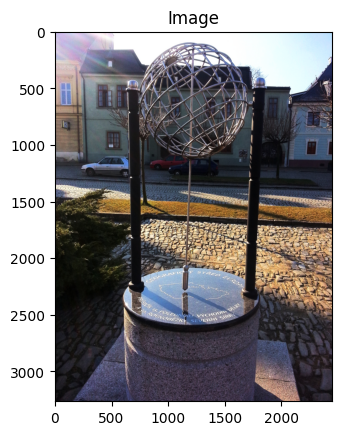

In [73]:
with tf.Session() as sess:
    sess.run(init)
    saver = tf.train.import_meta_graph('rnn-dura/rnn-my-model.meta')
    saver.restore(sess,tf.train.latest_checkpoint('rnn-dura/'))
    for tests in range(3):
        image_num = random.randint(0, sample_size - 1)
        caption = sess.run(final_prediction, feed_dict = {x_inp:train[image_num:image_num + 1]})
        print(caption.shape)
        caption = np.argmax(caption[:-1], 1)
        capt = ''
        for i in caption:
            capt += rev_dict[i] + ' '
        print('Predicted Caption:->', capt)
        orig_cap = np.argmax(train_caption[image_num:image_num + 1][0][1:-1].A, 1)
        orignalcaption = ''
        for i in orig_cap:
            orignalcaption += rev_dict[i] + ' '
        print('Orignal Caption:->', orignalcaption)
        plt.imshow(real_images[image_num])
        plt.title('Image')
        plt.show()